In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

import h5py

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *

In [10]:
#scan_name ="Ru_foil_monoscan_001"
# scan_name ="XES-L-cystine-timescan"
scan_name ="XES-L-cystine-2466p5eV-200fs"

# DIR_raw = "/sf/alvra/data/p18387/raw/scan_data/XES-L-cystine-timescan/"
# DIR_res = "/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/"
# DIR_json = "/sf/alvra/data/p18387/res/scan_info/"

DIR_raw = "/sf/alvra/data/p18387/raw/XES-L-cystine-2466p5eV-200fs/"
DIR_res = "/sf/alvra/data/p18387/res/data/XES-L-cystine-2466p5eV-200fs/"
DIR_json = "/sf/alvra/data/p18387/res/scan_info/"

!ls -lah -t $DIR_res

!hostname

listfile = os.listdir(DIR_res)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR_res)

total 32G
drwxrwsr-x. 14 ozerov_d p18387 4.0K Feb 23 13:01 ..
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:07 run_002292.JF02T09V02.h5
drwxr-sr-x.  2 ozerov_d p18387  32K Feb 23 08:07 .
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:07 run_002291.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:07 run_002290.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:06 run_002289.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:06 run_002288.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:06 run_002287.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:06 run_002286.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:06 run_002285.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:06 run_002284.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:05 run_002283.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:05 run_002282.JF02T09V02.h5
-rw-r--r--.  1 ozerov_d p18387 577M Feb 23 08:05 run_002281.JF02T09V02.h5

In [102]:
fn_crop = "run_002238.JF02T09V02.h5"
jf_file_crop = h5py.File(DIR_res + fn_crop, "r")
print (jf_file_crop)
print(list(jf_file_crop.keys()))

imagesROI1 = jf_file_crop["data/JF02T09V02/data_roi_1"]
imagesROI2 = jf_file_crop["data/JF02T09V02/data_roi_2"]
pulse_IDs = jf_file_crop["data/JF02T09V02/pulse_id"]
ROI_2 = jf_file_crop["data/JF02T09V02/roi_2"]

h5py.File.close
imagesROI2.shape
ROI_2

<HDF5 file "run_002238.JF02T09V02.h5" (mode r)>
['data', 'general']


<HDF5 dataset "roi_2": shape (2, 2), type "<i8">

In [100]:
img = imagesROI2[0][:]
img[img < 2] = 0
img[img > 10] = 0

<IPython.core.display.Javascript object>


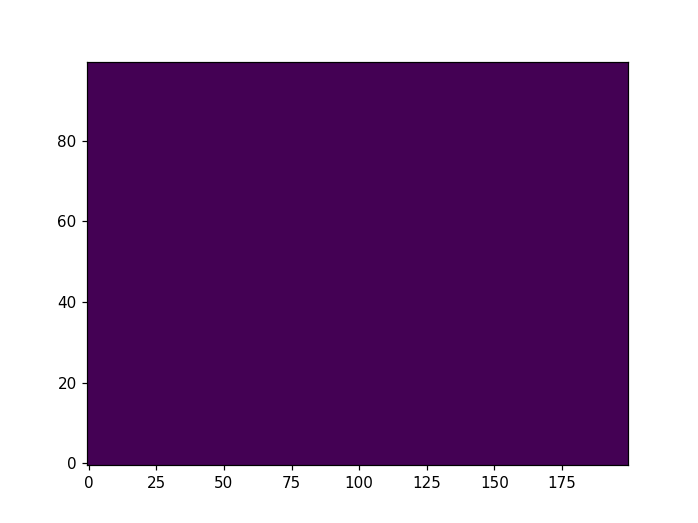

In [98]:
plt.figure()
plt.imshow(img, origin="lower", aspect='auto')
plt.show()

5000


<IPython.core.display.Javascript object>


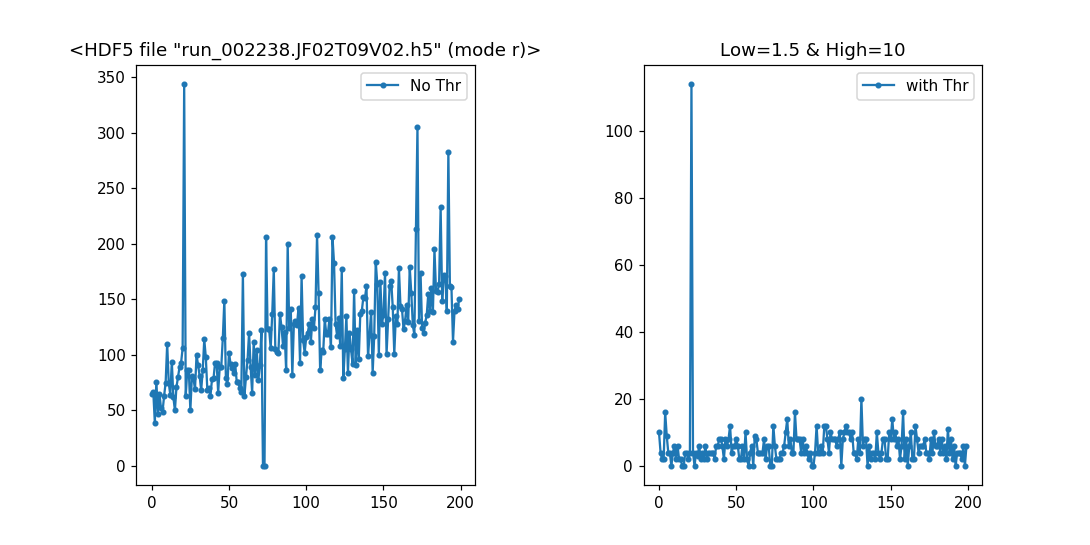

Text(0.5, 1.0, 'Low=1.5 & High=10')

In [105]:
nframes =len(pulse_IDs)
#nframes = 10
print (nframes)

total_roi = 0
total_roi_thr = 0
threshold_low = 1.5
threshold_high = 10

for i in range(nframes):
    image_roi = imagesROI2[i][:]
    image_roi_thr = image_roi
    total_roi += image_roi
    image_roi_thr[image_roi_thr < threshold_low] = 0
    image_roi_thr[image_roi_thr > threshold_high] = 0
    #image_roi_thr = convert_to_photon_num_range(image_roi_thr)
    total_roi_thr += image_roi_thr
    
total_line = total_roi.sum(axis = 0)
total_linethr = total_roi_thr.sum(axis = 0)
    
plt.figure(figsize = (10,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
plt.plot(total_line, label="No Thr", marker='.')
plt.legend(loc="best")
plt.title(jf_file_crop)

plt.subplot(122)
plt.plot(total_linethr, label="with Thr", marker='.')
plt.legend(loc="best")
plt.title("Low=" + str(threshold_low) +" & High="+ str(threshold_high))
#plt.ylim((0,100))

# New script in the next cell (single file)

In [218]:
#from glob import glob
#files = sorted(glob(DIR + "*"))

f = "run_002239"
filename_txt=str(f)
#files = ["RuBpy3_monoscan_006_step00{}".format(i) for i in range(15, 36)]
#files = ["run_000{}".format(i) for i in list(range(386, 400))+list(range(405, 410))]

threshold_low = 2
threshold_high = 10
Timezero = 177.35     ## This is mm from the stage

######################################################################################
clock = Clock()
spectrum_ON_roi0 = 0
spectrum_OFF_roi0 = 0
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
spectrum_ON_roi3 = 0
spectrum_OFF_roi3 = 0
energy_eV = 0
j = 0
        
#for f in files:
j +=1
JF_single_file_crop = DIR_res + f + ".JF02T09V02.h5"
BS_single_file = DIR_raw + f + ".BSREAD.h5"
    #print("Processing file %s" % (JF_single_file_crop))
    
   # print("\nFile", j, "of", len(files), ": Processing:", JF_single_file_crop.split("/")[-1])
print("Processing:", JF_single_file_crop.split("/")[-1])
    
nshots = None  # put this to None for ALL images
#   nshots = None

delay, pids = load_single_channel_pulseID(BS_single_file, channel_delay, 50)
delay = [x for x in delay if (x > 0)]
Delay_mm_single = np.mean(delay)
Delay_ps_single = (Delay_mm_single - Timezero)*2/(3e8*1e3*1e-12) # in ps, change to right t0 !
    
with h5py.File(JF_single_file_crop, "r") as juf:
    imagesROI1 = juf["data/JF02T09V02/data_roi_1"][:nshots]
    ROI1 = juf["data/JF02T09V02/roi_1"][:]
    imagesROI2 = juf["data/JF02T09V02/data_roi_2"][:nshots]
    ROI2 = juf["data/JF02T09V02/roi_2"][:]
    pulse_ids = juf["data/JF02T09V02/pulse_id"][:nshots].T[0]
    frames = len(pulse_ids)
        
    print ("Found {} shots".format(frames))
        
reprate_on, reprate_off = load_data._make_reprates_on_off(pulse_ids, 50, 25)
    
imagesROI2_ON  = imagesROI2[reprate_on]
imagesROI2_OFF  = imagesROI2[reprate_off]
imagesROI1_ON  = imagesROI1[reprate_on]
imagesROI1_OFF  = imagesROI1[reprate_off]
pulse_ids_on    = pulse_ids[reprate_on]
pulse_ids_off   = pulse_ids[reprate_off]
    
imagesROI1_ON_thr = imagesROI1_ON.copy()
imagesROI1_ON_thr[imagesROI1_ON < threshold_low] = 0
imagesROI1_ON_thr[imagesROI1_ON > threshold_high] = 0
    
imagesROI1_OFF_thr = imagesROI1_OFF.copy()
imagesROI1_OFF_thr[imagesROI1_OFF < threshold_low] = 0
imagesROI1_OFF_thr[imagesROI1_OFF > threshold_high] = 0
    
imagesROI2_ON_thr = imagesROI2_ON.copy()
imagesROI2_ON_thr[imagesROI2_ON < threshold_low] = 0
imagesROI2_ON_thr[imagesROI2_ON > threshold_high] = 0
    
imagesROI2_OFF_thr = imagesROI2_OFF.copy()
imagesROI2_OFF_thr[imagesROI2_OFF < threshold_low] = 0
imagesROI2_OFF_thr[imagesROI2_OFF > threshold_high] = 0
    
spectrum_ON_roi2  = imagesROI2_ON_thr.sum(axis = 1).sum(axis = 0)
spectrum_OFF_roi2 = imagesROI2_OFF_thr.sum(axis = 1).sum(axis = 0)
spectrum_ON_roi1  = imagesROI1_ON_thr.sum(axis = 1).sum(axis = 0)
spectrum_OFF_roi1 = imagesROI1_OFF_thr.sum(axis = 1).sum(axis = 0)
    
spectrum_ON_roi2 = spectrum_ON_roi2.astype('float32')
spectrum_OFF_roi2 = spectrum_OFF_roi2.astype('float32') 
spectrum_ON_roi1 = spectrum_ON_roi1.astype('float32')
spectrum_OFF_roi1 = spectrum_OFF_roi1.astype('float32') 
    
#
print ("It took", clock.tick(), "seconds to process this file")
    
print ("\nJob done! It took", clock.tock(), "seconds to process", len(f), "file(s)")


Processing: run_002239.JF02T09V02.h5
Found 5000 shots
It took 1.9 seconds to process this file

Job done! It took 1.9 seconds to process 10 file(s)


### ROI1: Kbeta

<IPython.core.display.Javascript object>


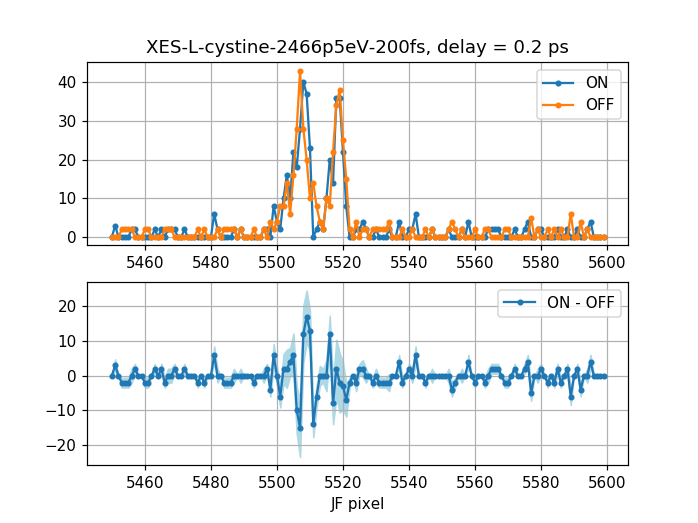

In [219]:
bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(ROI1[1][0],ROI1[1][1])

spectra_on_rebin1  = bin_sum(spectra_on,  bin_)
spectra_off_rebin1 = bin_sum(spectra_off, bin_)
x_axis_rebin1 = bin_mean(x_axis, bin_)

spectra_on_err1  = np.sqrt(spectra_on_rebin1)
spectra_off_err1 = np.sqrt(spectra_off_rebin1)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.xlabel("JF pixel")
plt.grid()


plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

In [210]:
savedir = "/das/work/p18/p18387/exported_data/"
filename_txt1 = savedir + filename_txt + "_kb.txt"
output_matrix=[]
output_matrix=np.array(np.arange(ROI1[1][0],ROI1[1][1]))
output_matrix=np.vstack((output_matrix,np.array(spectrum_ON_roi1 )))
output_matrix=np.vstack((output_matrix,np.array(spectrum_OFF_roi1 )))
np.savetxt(filename_txt1,np.transpose(output_matrix),newline='\n', delimiter='\t', header='x \t on_kb \t off_kb')
print(filename_txt1)
# filename_txt2 = savedir + filename_txt + "_ka.txt"
# output_matrix=[]
# output_matrix=np.array(np.arange(ROI2[1][0],ROI2[1][1]))
# output_matrix=np.vstack((output_matrix,np.array(spectrum_ON_roi2 )))
# output_matrix=np.vstack((output_matrix,np.array(spectrum_OFF_roi2 )))
# np.savetxt(filename_txt2,np.transpose(output_matrix),newline='\n', delimiter='\t', header='x \t on_ka \t off_ka')

/das/work/p18/p18387/exported_data/run_002292_kb.txt


<IPython.core.display.Javascript object>


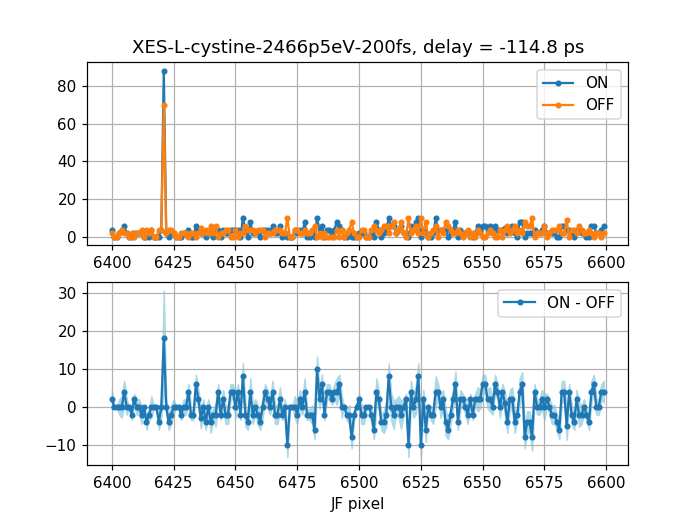

In [20]:
bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi2.copy()
spectra_off = spectrum_OFF_roi2.copy()

x_axis = np.arange(ROI2[1][0],ROI2[1][1])

spectra_on_rebin1  = bin_sum(spectra_on,  bin_)
spectra_off_rebin1 = bin_sum(spectra_off, bin_)
x_axis_rebin1 = bin_mean(x_axis, bin_)

spectra_on_err1  = np.sqrt(spectra_on_rebin1)
spectra_off_err1 = np.sqrt(spectra_off_rebin1)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.xlabel("JF pixel")
plt.grid()


plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

# New script in the next cell (scans) 

In [34]:
run_start = 1705
run_end = 1721
first_file = 0

num_files = run_end - run_start + 1
print (num_files)

from glob import glob
print (DIR_res + scan_name)
scan_data = list((sorted(glob(DIR_res + "*"))))
scan_data_scan = list(scan_data[first_file:first_file + num_files])
scan_data_scan

17
/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/XES-L-cystine-timescan


['/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001705.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001706.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001707.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001708.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001709.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001710.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001711.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001712.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001713.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_001714.JF02T09V02.h5',
 '/sf/alvra/data/p18387/res/data/scan_data/XES-L-cystine-timescan/run_

In [35]:
scan_name = "XES-L-cystine-timescan"          # you need to change only this name
scan_range =".run001705-001721"

threshold_low = 2
threshold_high = 10


######################################################################################
#from glob import glob
#scan_data = list(reversed(sorted(glob(DIR + "*"))))

fn_json = DIR_json + scan_name + scan_range + ".json"
scan_data_json = load_scan_data(fn_json)

Energy_eV = []
Delay_mm = []

XES_transient_roi1 =[]
XES_transient_roi2 = []

clock = Clock()
num_scan_files = len(scan_data_scan)
print("\nProcessing", num_scan_files, "files total")

for i, fn in enumerate(scan_data_scan):
    
    juf_scan = scan_data_scan[i]
    bsf_scan = scan_data_json[i][0]
    
    print("\nFile", i+1, "of", num_scan_files, ": Processing:", juf_scan)
    print(bsf_scan)
    
    nshots = None  # put this to None for ALL images
#   nshots = None
    
    energy, pids = load_single_channel_pulseID(bsf_scan, channel_energy, 50)
    energy = [x for x in energy if (x > 0)]
    Energy_eV.append(np.mean(energy))
    
    delay, pids = load_single_channel_pulseID(bsf_scan, channel_delay, 50)
    delay = [x for x in delay if (x > 0)]
    Delay_mm.append(np.mean(delay))
    
    with h5py.File(juf_scan, "r") as juf:
        imagesROI1 = juf["data/JF02T09V02/data_roi_1"][:nshots]
        ROI1 = juf["data/JF02T09V02/roi_1"][:]
        imagesROI2 = juf["data/JF02T09V02/data_roi_2"][:nshots]
        ROI2 = juf["data/JF02T09V02/roi_2"][:]
        pulse_ids = juf["data/JF02T09V02/pulse_id"][:nshots].T[0]
        frames = len(pulse_ids)
        
    print ("Found {} shots".format(frames))
    
    reprate_on, reprate_off = load_data._make_reprates_on_off(pulse_ids, 50, 25)
    
    imagesROI2_ON  = imagesROI2[reprate_on]
    imagesROI2_OFF  = imagesROI2[reprate_off]
    imagesROI1_ON  = imagesROI1[reprate_on]
    imagesROI1_OFF  = imagesROI1[reprate_off]
    pulse_ids_on    = pulse_ids[reprate_on]
    pulse_ids_off   = pulse_ids[reprate_off]
    
    spectrum_ON_roi2  = imagesROI2_ON.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = imagesROI2_OFF.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi1  = imagesROI1_ON.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = imagesROI1_OFF.sum(axis = 1).sum(axis = 0)
    
    spectrum_ON_roi2 = spectrum_ON_roi2.astype('float32')
    spectrum_OFF_roi2 = spectrum_OFF_roi2.astype('float32') 
    spectrum_ON_roi1 = spectrum_ON_roi1.astype('float32')
    spectrum_OFF_roi1 = spectrum_OFF_roi1.astype('float32') 
    
    XES_transient_roi1.append(np.abs(spectrum_ON_roi1 - spectrum_OFF_roi1))
    XES_transient_roi2.append(np.abs(spectrum_ON_roi2 - spectrum_OFF_roi2))

    print ("It took", clock.tick(), "seconds to process this file")
    clear_output(wait=True)
XES_transient_roi1=np.array(XES_transient_roi1)
XES_transient_roi2=np.array(XES_transient_roi2)
Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)

print ("\nJob done! It took", clock.tock(), "seconds to process", num_scan_files, "file(s)")



Job done! It took 111.75 seconds to process 17 file(s)


<IPython.core.display.Javascript object>


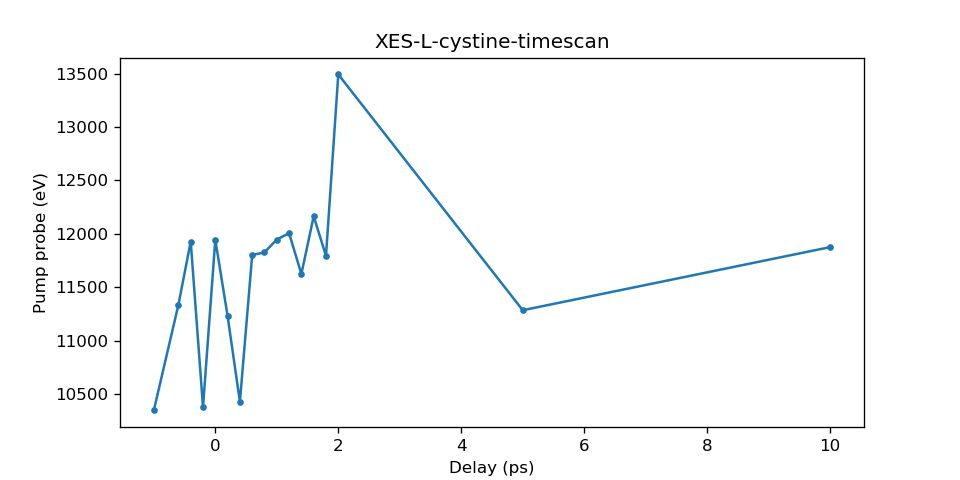

In [36]:
Timezero = 194.6   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

plt.figure(figsize=(8,4))
plt.plot(Delay_ps,XES_transient_roi1.sum(axis = 1), marker ='.')
plt.xlabel("Delay (ps)")
plt.ylabel("Pump probe (eV)")

plt.title(scan_name)
plt.show()


In [1]:
savedir = "/das/work/p18/p18387/exported_data/"
filename_txt1 = savedir + filename_txt + "_kb.txt"
output_matrix=[]
output_matrix=np.array(np.arange(ROI1[1][0],ROI1[1][1]))
output_matrix=np.vstack((output_matrix,np.array(spectrum_ON_roi1 )))
output_matrix=np.vstack((output_matrix,np.array(spectrum_OFF_roi1 )))
np.savetxt(filename_txt1,np.transpose(output_matrix),newline='\n', delimiter='\t', header='x \t on_kb \t off_kb')

filename_txt2 = savedir + filename_txt + "_ka.txt"
output_matrix=[]
output_matrix=np.array(np.arange(ROI2[1][0],ROI2[1][1]))
output_matrix=np.vstack((output_matrix,np.array(spectrum_ON_roi2 )))
output_matrix=np.vstack((output_matrix,np.array(spectrum_OFF_roi2 )))
np.savetxt(filename_txt2,np.transpose(output_matrix),newline='\n', delimiter='\t', header='x \t on_ka \t off_ka')

NameError: name 'filename_txt' is not defined

In [257]:
scan6 = (XES_transient_roi1.sum(axis = 1)).copy()
delay6 = Delay_ps.copy()

<IPython.core.display.Javascript object>


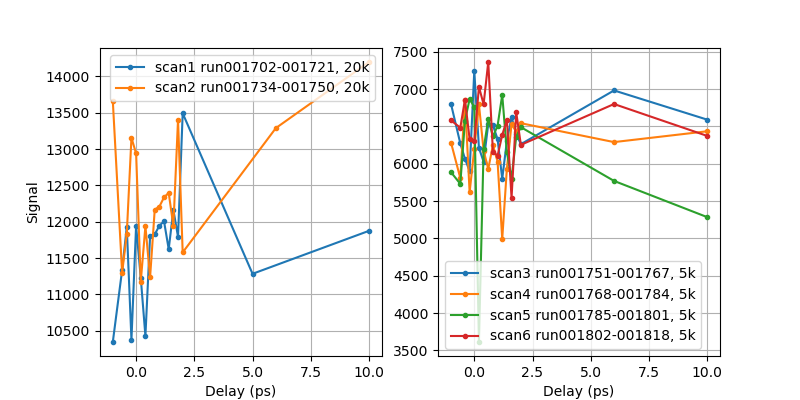

In [258]:
plt.figure(figsize=(8,4))
#plt.title(scan_name)
plt.subplot(121)

plt.plot(delay1,scan1, label = "scan1 run001702-001721, 20k", marker ='.')
plt.plot(delay2,scan2, label = "scan2 run001734-001750, 20k", marker ='.')
plt.xlabel("Delay (ps)")
plt.ylabel("Signal")
plt.legend(loc="best")
plt.grid()

plt.subplot(122)
plt.plot(delay3,scan3, label = "scan3 run001751-001767, 5k", marker ='.')
plt.plot(delay4,scan4, label = "scan4 run001768-001784, 5k", marker ='.')
plt.plot(delay5,scan5, label = "scan5 run001785-001801, 5k", marker ='.')
plt.plot(delay6,scan6, label = "scan6 run001802-001818, 5k", marker ='.')


plt.xlabel("Delay (ps)")


plt.legend(loc="best")
plt.grid()

plt.show()


<IPython.core.display.Javascript object>


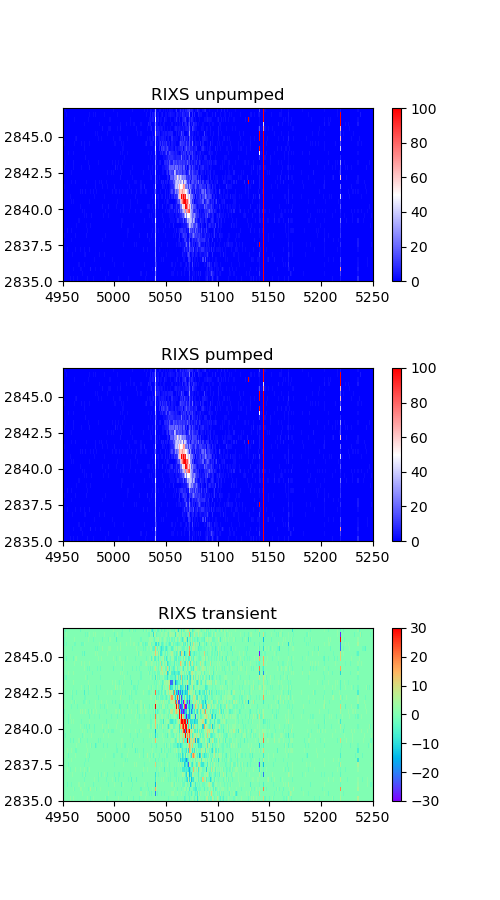

In [56]:
roi1 = [4300, 4600]
roi2 = [4950, 5250]
roi3 = [8500, 8700]
roi4 = [6950, 7250]

plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_pumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
plt.title("RIXS unpumped")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
plt.title("RIXS pumped")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi2, aspect = 'auto', cmap = "rainbow", origin ="lower", extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]], vmin=-30, vmax=30)
plt.title("RIXS transient")
plt.colorbar()
plt.show()

# Next cells: old code (still works...)

# Set the ROIs (roi1 & roi2 in pixels) in the next cell

# The next cell is to analyse a single file or a series of identical ones to be summed up